In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Constants
MAX_PIPES = 40  # For pipe1 through pipe39
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PipeNetwork:
    def __init__(self, max_pipes=MAX_PIPES):
        """
        Helper class to represent the pipe network structure.
        """
        self.max_pipes = max_pipes
        self.parent_map = {}  # Maps pipe_id -> parent_id
        self.child_map = {}   # Maps pipe_id -> list of child pipe_ids
        self.pipe_data = {}   # Maps pipe_id -> (length, radius, has_receiver)
        self.ancestors = {}   # Maps pipe_id -> list of ancestor pipe_ids
        self.descendants = {} # Maps pipe_id -> list of descendant pipe_ids
        self.distances = {}   # Maps (pipe_id1, pipe_id2) -> network distance
        
    def add_pipe(self, pipe_id, parent_id, length, radius, has_receiver):
        """Add a pipe to the network with its properties."""
        self.parent_map[pipe_id] = parent_id
        self.pipe_data[pipe_id] = (length, radius, has_receiver)
        
        # Update child_map
        if parent_id not in self.child_map and parent_id != -1:
            self.child_map[parent_id] = []
        if parent_id != -1:
            self.child_map[parent_id].append(pipe_id)
            
    def build_network_structure(self):
        """Build additional network structure information after all pipes are added."""
        # Calculate ancestors for each pipe
        for pipe_id in self.pipe_data.keys():
            self.ancestors[pipe_id] = self._get_ancestors(pipe_id)
            
        # Calculate descendants for each pipe
        for pipe_id in self.pipe_data.keys():
            self.descendants[pipe_id] = self._get_descendants(pipe_id)
            
        # Calculate network distances between all pairs of pipes
        pipe_ids = list(self.pipe_data.keys())
        for i in range(len(pipe_ids)):
            for j in range(i, len(pipe_ids)):
                pipe_id1 = pipe_ids[i]
                pipe_id2 = pipe_ids[j]
                distance = self._calculate_network_distance(pipe_id1, pipe_id2)
                self.distances[(pipe_id1, pipe_id2)] = distance
                self.distances[(pipe_id2, pipe_id1)] = distance
    
    def _get_ancestors(self, pipe_id):
        """Get all ancestors (parent, grandparent, etc.) of a pipe."""
        ancestors = []
        current = pipe_id
        while self.parent_map.get(current, -1) != -1:
            current = self.parent_map[current]
            ancestors.append(current)
        return ancestors
    
    def _get_descendants(self, pipe_id):
        """Get all descendants of a pipe recursively."""
        descendants = []
        if pipe_id in self.child_map:
            children = self.child_map[pipe_id]
            descendants.extend(children)
            for child in children:
                descendants.extend(self._get_descendants(child))
        return descendants
    
    def _calculate_network_distance(self, pipe_id1, pipe_id2):
        """
        Calculate the network distance (number of hops) between two pipes.
        """
        if pipe_id1 == pipe_id2:
            return 0
            
        # Check if pipe2 is an ancestor of pipe1
        if pipe_id2 in self.ancestors.get(pipe_id1, []):
            return len(self._get_path_to_ancestor(pipe_id1, pipe_id2))
            
        # Check if pipe1 is an ancestor of pipe2
        if pipe_id1 in self.ancestors.get(pipe_id2, []):
            return len(self._get_path_to_ancestor(pipe_id2, pipe_id1))
            
        # Find nearest common ancestor
        ancestors1 = self.ancestors.get(pipe_id1, [])
        ancestors2 = self.ancestors.get(pipe_id2, [])
        
        for ancestor in ancestors1:
            if ancestor in ancestors2:
                # Distance = path from pipe1 to ancestor + path from pipe2 to ancestor
                return (len(self._get_path_to_ancestor(pipe_id1, ancestor)) + 
                        len(self._get_path_to_ancestor(pipe_id2, ancestor)))
                
        # No common ancestor found (should not happen in a tree)
        return self.max_pipes
        
    def _get_path_to_ancestor(self, pipe_id, ancestor_id):
        """Get the path from a pipe to one of its ancestors."""
        path = []
        current = pipe_id
        while current != ancestor_id and self.parent_map.get(current, -1) != -1:
            path.append(current)
            current = self.parent_map[current]
        if current == ancestor_id:
            path.append(ancestor_id)
        return path
    
    def get_network_features(self, emitter_pipe_id=None):
        """
        Generate network-aware features for all pipes.
        
        Returns:
            numpy array of shape (max_pipes, feature_dim)
        """
        feature_dim = 10  # Adjust based on features below
        features = np.zeros((self.max_pipes, feature_dim), dtype=np.float32)
        
        for pipe_id, (length, radius, has_receiver) in self.pipe_data.items():
            if pipe_id >= self.max_pipes:
                continue
                
            # Base pipe features
            parent_id = self.parent_map.get(pipe_id, -1)
            
            # Network structural features
            num_ancestors = len(self.ancestors.get(pipe_id, []))
            num_descendants = len(self.descendants.get(pipe_id, []))
            
            # Distance to emitter if known
            distance_to_emitter = 0
            
            # Distance to root
            distance_to_root = len(self.ancestors.get(pipe_id, []))
            
            # Calculate shortest distance to a receiver
            min_distance_to_receiver = self.max_pipes
            for other_id, (_, _, other_has_receiver) in self.pipe_data.items():
                if other_has_receiver:
                    dist = self.distances.get((pipe_id, other_id), self.max_pipes)
                    min_distance_to_receiver = min(min_distance_to_receiver, dist)
            
            # Normalize features
            features[pipe_id-1] = [
                pipe_id / self.max_pipes,                  # Pipe ID (normalized)
                parent_id / self.max_pipes if parent_id > 0 else -0.1,  # Parent ID (normalized)
                length,                                    # Length
                radius,                                    # Radius
                1.0 if has_receiver else 0.0,              # Has receiver flag
                num_ancestors / self.max_pipes,            # Normalized number of ancestors
                num_descendants / self.max_pipes,          # Normalized number of descendants
                distance_to_root / self.max_pipes,         # Normalized distance to root
                distance_to_emitter / self.max_pipes,      # Normalized distance to emitter (0 during inference)
                min_distance_to_receiver / self.max_pipes  # Normalized distance to nearest receiver
            ]
            
        return features

In [2]:
class EnhancedEmitterDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.run_folders = sorted([
            f for f in os.listdir(data_dir) 
            if os.path.isdir(os.path.join(data_dir, f)) and not f.startswith('.')
        ])
        
        # Process all runs
        self.features = []
        self.targets = []
        self._process_runs()
        
    def _process_runs(self):
        print(f"Processing {len(self.run_folders)} simulation runs...")
        
        for run_folder in tqdm(self.run_folders):
            try:
                features, target = self._process_single_run(run_folder)
                self.features.append(features)
                self.targets.append(target)
            except Exception as e:
                print(f"Error processing run folder {run_folder}: {str(e)}")
                
        # Convert lists to tensors
        self.features = torch.tensor(np.array(self.features), dtype=torch.float32)
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.float32)
        
    def _process_single_run(self, run_folder):
        run_path = os.path.join(self.data_dir, run_folder)
        
        # Create pipe network
        network = PipeNetwork()
        receiver_data = {}
        
        # Process pipe and receiver data
        pipe_folders = sorted([
            f for f in os.listdir(run_path) 
            if os.path.isdir(os.path.join(run_path, f)) and f.startswith('pipe')
        ], key=lambda x: int(x.replace('pipe', '')))
        
        # First pass: collect pipe structure information
        for pipe_folder in pipe_folders:
            pipe_id = int(pipe_folder.replace('pipe', ''))
            if pipe_id > MAX_PIPES:
                continue
                
            pipe_path = os.path.join(run_path, pipe_folder)
            
            # Read pipe data
            sim_data_path = os.path.join(pipe_path, "simulation_data.txt")
            if os.path.exists(sim_data_path):
                with open(sim_data_path, 'r') as f:
                    line = f.readline().strip().split()
                    p_id = int(line[0])
                    parent_id = int(line[1])
                    length = float(line[2])
                    radius = float(line[3])
                    
                    # Check for receivers
                    has_receiver = len(glob.glob(os.path.join(pipe_path, "#*-Ring type.txt"))) > 0
                    
                    # Add pipe to network
                    network.add_pipe(p_id, parent_id, length, radius, has_receiver)
            
            # Collect receiver data
            receiver_files = glob.glob(os.path.join(pipe_path, "#*-Ring type.txt"))
            for rec_file in receiver_files:
                with open(rec_file, 'r') as f:
                    # Read receiver location and stats
                    first_line = f.readline().strip().split()
                    second_line = f.readline().strip().split(',')
                    
                    rec_pipe_id = int(first_line[0])
                    r_coord = float(first_line[1])
                    z_coord = float(first_line[2])
                    
                    # Parse statistics
                    stats = [float(val.strip()) for val in second_line[:7]]  # Take up to 7 stats
                    
                    # Store receiver data
                    if rec_pipe_id not in receiver_data:
                        receiver_data[rec_pipe_id] = []
                    receiver_data[rec_pipe_id].append((r_coord, z_coord, stats))
        
        # Build network structure once all pipes are added
        network.build_network_structure()
        
        # Read target emitter location
        target_path = os.path.join(run_path, "targetOutput.txt")
        with open(target_path, 'r') as f:
            line = f.readline().strip().split()
            emitter_pipe_id = int(line[0])
            emitter_r = float(line[1])
            emitter_z = float(line[2]) if len(line) > 2 else 0.0
        
        # Get enhanced network-aware features
        network_features = network.get_network_features(emitter_pipe_id)
        
        # Process receiver data into a fixed-size feature vector
        receiver_features = np.zeros((MAX_PIPES, 10), dtype=np.float32)
        for pipe_id, receivers in receiver_data.items():
            if pipe_id >= MAX_PIPES:
                continue
                
            # Average stats if multiple receivers in the same pipe
            avg_r = np.mean([r for r, _, _ in receivers])
            avg_z = np.mean([z for _, z, _ in receivers])
            avg_stats = np.mean([s for _, _, s in receivers], axis=0)
            
            # Normalize pipe ID
            receiver_features[pipe_id-1] = np.concatenate([
                [pipe_id / MAX_PIPES, avg_r, avg_z],
                avg_stats
            ])
        
        # Flatten and combine features
        flat_network_features = network_features.flatten()
        flat_receiver_features = receiver_features.flatten()
        
        # Create final feature vector
        combined_features = np.concatenate([flat_network_features, flat_receiver_features])
        
        # Create target vector with normalized pipe ID
        target = np.array([
            emitter_pipe_id / MAX_PIPES,  # Normalized pipe ID
            emitter_r,                    # r coordinate
            emitter_z                     # z coordinate
        ], dtype=np.float32)
        
        return combined_features, target
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [3]:
class TreeAwareEmitterModel(nn.Module):
    def __init__(self, input_dim):
        super(TreeAwareEmitterModel, self).__init__()
        
        # Separate branches for network structure and receiver data
        self.network_encoder = nn.Sequential(
            nn.Linear(MAX_PIPES * 10, 512),  # 10 features per pipe
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        self.receiver_encoder = nn.Sequential(
            nn.Linear(MAX_PIPES * 10, 512),  # 10 features per receiver
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        # Combined layers
        self.combined_layers = nn.Sequential(
            nn.Linear(512, 256),  # 256 + 256 from both branches
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Separate heads for pipe classification and position regression
        self.pipe_head = nn.Linear(64, 1)  # Single value for pipe ID
        self.position_head = nn.Linear(64, 2)  # r, z coordinates
        
    def forward(self, x):
        # Split the input into network and receiver features
        network_features = x[:, :MAX_PIPES * 10]
        receiver_features = x[:, MAX_PIPES * 10:]
        
        # Process each branch
        network_encoding = self.network_encoder(network_features)
        receiver_encoding = self.receiver_encoder(receiver_features)
        
        # Combine branches
        combined = torch.cat((network_encoding, receiver_encoding), dim=1)
        features = self.combined_layers(combined)
        
        # Get predictions from each head
        pipe_pred = self.pipe_head(features)
        position_pred = self.position_head(features)
        
        # Combine predictions into single output
        return torch.cat((pipe_pred, position_pred), dim=1)

In [4]:
def custom_loss_function(pred, target, pipe_weight=5.0):
    """
    Custom loss that weights pipe prediction higher than position prediction.
    
    Args:
        pred: Model predictions [pipe_id, r, z]
        target: Ground truth targets [pipe_id, r, z]
        pipe_weight: Weight factor for pipe prediction loss
    """
    # MSE for pipe ID - we're treating it as regression for simplicity
    pipe_loss = nn.functional.mse_loss(pred[:, 0:1], target[:, 0:1])
    
    # MSE for position (r, z)
    position_loss = nn.functional.mse_loss(pred[:, 1:], target[:, 1:])
    
    # Weighted sum
    return pipe_weight * pipe_loss + position_loss

Creating datasets...
Processing 1101 simulation runs...


  0%|          | 0/1101 [00:00<?, ?it/s]

100%|██████████| 1101/1101 [00:03<00:00, 353.08it/s]


Error processing run folder 2025.06.15-19.18.52.973: invalid literal for int() with base 10: 'Non'
Training: 770 samples, Validation: 165 samples, Test: 165 samples
Model initialized with input dimension: 800
Training on: cpu


New best model saved (loss: 0.078207)
Epoch 10/500 | Train loss: 0.048529 | Val loss: 0.078207 | Time: 0.17s


Epoch 20/500 | Train loss: 0.041299 | Val loss: 0.222564 | Time: 0.16s


Epoch 30/500 | Train loss: 0.034993 | Val loss: 0.111397 | Time: 0.26s


New best model saved (loss: 0.075427)
Epoch 40/500 | Train loss: 0.031994 | Val loss: 0.075427 | Time: 0.17s


Epoch 50/500 | Train loss: 0.025255 | Val loss: 0.079175 | Time: 0.16s


Epoch 60/500 | Train loss: 0.025831 | Val loss: 0.110526 | Time: 0.16s


Epoch 70/500 | Train loss: 0.029078 | Val loss: 0.144651 | Time: 0.16s


Epoch 80/500 | Train loss: 0.022678 | Val loss: 0.080646 | Time: 0.16s


Epoch 90/500 | Train loss: 0.022360 | Val loss: 0.407119 | Time: 0.16s


Epoch 100/500 | Train loss: 0.018941 | Val loss: 0.134403 | Time: 0.16s


Epoch 110/500 | Train loss: 0.017306 | Val loss: 0.251658 | Time: 0.16s


Epoch 120/500 | Train loss: 0.017295 | Val loss: 0.089877 | Time: 0.16s


Epoch 130/500 | Train loss: 0.017729 | Val loss: 0.087698 | Time: 0.17s


Epoch 140/500 | Train loss: 0.018514 | Val loss: 0.090250 | Time: 0.16s


New best model saved (loss: 0.073581)
Epoch 150/500 | Train loss: 0.018516 | Val loss: 0.073581 | Time: 0.16s


Epoch 160/500 | Train loss: 0.018175 | Val loss: 0.084889 | Time: 0.16s


Epoch 170/500 | Train loss: 0.013608 | Val loss: 0.087145 | Time: 0.16s


Epoch 180/500 | Train loss: 0.017292 | Val loss: 0.082690 | Time: 0.16s


Epoch 190/500 | Train loss: 0.014742 | Val loss: 0.084817 | Time: 0.16s


Epoch 200/500 | Train loss: 0.014236 | Val loss: 0.078574 | Time: 0.16s


Epoch 210/500 | Train loss: 0.015161 | Val loss: 0.084505 | Time: 0.16s


Epoch 220/500 | Train loss: 0.016592 | Val loss: 0.076656 | Time: 0.16s


Epoch 230/500 | Train loss: 0.012100 | Val loss: 0.083334 | Time: 0.17s


Epoch 240/500 | Train loss: 0.013537 | Val loss: 0.088596 | Time: 0.16s


Epoch 250/500 | Train loss: 0.014770 | Val loss: 0.084163 | Time: 0.17s


Epoch 260/500 | Train loss: 0.013394 | Val loss: 0.085299 | Time: 0.22s


Epoch 270/500 | Train loss: 0.015569 | Val loss: 0.083821 | Time: 0.16s


Epoch 280/500 | Train loss: 0.011803 | Val loss: 0.084591 | Time: 0.16s


Epoch 290/500 | Train loss: 0.012303 | Val loss: 0.090754 | Time: 0.16s


Epoch 300/500 | Train loss: 0.012174 | Val loss: 0.082116 | Time: 0.16s


Epoch 310/500 | Train loss: 0.011738 | Val loss: 0.085727 | Time: 0.16s


Epoch 320/500 | Train loss: 0.009999 | Val loss: 0.086894 | Time: 0.16s


Epoch 330/500 | Train loss: 0.008538 | Val loss: 0.085068 | Time: 0.16s


Epoch 340/500 | Train loss: 0.008346 | Val loss: 0.082525 | Time: 0.16s


Epoch 350/500 | Train loss: 0.012203 | Val loss: 0.080778 | Time: 0.17s


Epoch 360/500 | Train loss: 0.012945 | Val loss: 0.082949 | Time: 0.16s


Epoch 370/500 | Train loss: 0.011663 | Val loss: 0.086863 | Time: 0.23s


Epoch 380/500 | Train loss: 0.010732 | Val loss: 0.087197 | Time: 0.16s


Epoch 390/500 | Train loss: 0.010946 | Val loss: 0.083258 | Time: 0.19s


Epoch 400/500 | Train loss: 0.009723 | Val loss: 0.083153 | Time: 0.16s


Epoch 410/500 | Train loss: 0.010049 | Val loss: 0.084657 | Time: 0.16s


Epoch 420/500 | Train loss: 0.008640 | Val loss: 0.080988 | Time: 0.16s


Epoch 430/500 | Train loss: 0.008302 | Val loss: 0.081415 | Time: 0.16s


Epoch 440/500 | Train loss: 0.010472 | Val loss: 0.086778 | Time: 0.16s


Epoch 450/500 | Train loss: 0.008751 | Val loss: 0.082218 | Time: 0.16s


Epoch 460/500 | Train loss: 0.008123 | Val loss: 0.081924 | Time: 0.16s


Epoch 470/500 | Train loss: 0.010491 | Val loss: 0.083079 | Time: 0.16s


Epoch 480/500 | Train loss: 0.010339 | Val loss: 0.086920 | Time: 0.16s


Epoch 490/500 | Train loss: 0.009109 | Val loss: 0.088704 | Time: 0.16s


Epoch 500/500 | Train loss: 0.007655 | Val loss: 0.082820 | Time: 0.16s


Testing: 100%|██████████| 6/6 [00:00<00:00, 700.45it/s]



Test Results:
Test Loss: 0.016154
Pipe Prediction Accuracy: 3.64%
Average Position Error: 0.001954 units


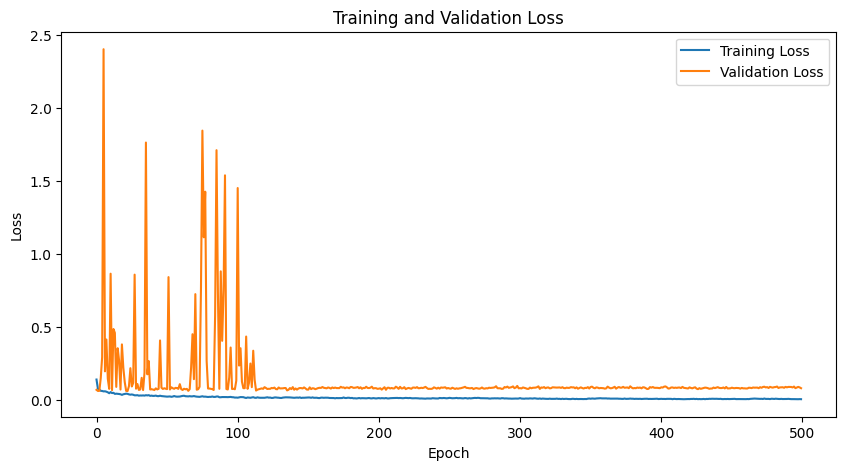

In [5]:
def train_and_evaluate(data_dir, epochs=500, batch_size=32, lr=0.001):
    """
    Train and evaluate the tree-aware emitter localization model.
    
    Args:
        data_dir: Directory containing simulation runs
        epochs: Number of training epochs
        batch_size: Batch size for training
        lr: Learning rate
    """
    # Create dataset
    print("Creating datasets...")
    full_dataset = EnhancedEmitterDataset(data_dir)
    
    # Split into train, validation, test
    dataset_size = len(full_dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size, test_size]
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    print(f"Training: {len(train_dataset)} samples, Validation: {len(val_dataset)} samples, Test: {len(test_dataset)} samples")
    
    # Calculate input dimension and initialize model
    sample_features, _ = full_dataset[0]
    input_dim = sample_features.shape[0]
    
    model = TreeAwareEmitterModel(input_dim).to(DEVICE)
    print(f"Model initialized with input dimension: {input_dim}")
    print(f"Training on: {DEVICE}")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        epoch_loss = 0
        start_time = time.time()
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for features, targets in loop:
            features, targets = features.to(DEVICE), targets.to(DEVICE)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(features)
            loss = custom_loss_function(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            batch_loss = loss.item()
            epoch_loss += batch_loss * features.size(0)
            loop.set_postfix({"loss": batch_loss})
            
        avg_train_loss = epoch_loss / len(train_dataset)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(DEVICE), targets.to(DEVICE)
                outputs = model(features)
                loss = custom_loss_function(outputs, targets)
                val_loss += loss.item() * features.size(0)
                
        avg_val_loss = val_loss / len(val_dataset)
        val_losses.append(avg_val_loss)
        
        if epoch % 10 == 0:
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), "best_emitter_model.pt")
                print(f"New best model saved (loss: {best_val_loss:.6f})")
                
            elapsed = time.time() - start_time
            print(f"Epoch {epoch}/{epochs} | Train loss: {avg_train_loss:.6f} | Val loss: {avg_val_loss:.6f} | Time: {elapsed:.2f}s")
        

    # Load best model for testing
    model.load_state_dict(torch.load("best_emitter_model.pt"))
    
    # Test evaluation
    model.eval()
    test_loss = 0
    pipe_correct = 0
    position_errors = []
    
    with torch.no_grad():
        for features, targets in tqdm(test_loader, desc="Testing"):
            features, targets = features.to(DEVICE), targets.to(DEVICE)
            outputs = model(features)
            
            # Calculate test loss
            loss = custom_loss_function(outputs, targets, pipe_weight=1.0)  # Equal weighting for evaluation
            test_loss += loss.item() * features.size(0)
            
            # Convert normalized pipe IDs back to absolute IDs
            pred_pipe_ids = torch.round(outputs[:, 0] * MAX_PIPES).long()
            true_pipe_ids = torch.round(targets[:, 0] * MAX_PIPES).long()
            
            # Check pipe prediction accuracy
            pipe_correct += (pred_pipe_ids == true_pipe_ids).sum().item()
            
            # Calculate position errors
            position_error = torch.sqrt(
                (outputs[:, 1] - targets[:, 1])**2 + (outputs[:, 2] - targets[:, 2])**2
            )
            position_errors.extend(position_error.cpu().numpy())
            
    # Calculate metrics
    avg_test_loss = test_loss / len(test_dataset)
    pipe_accuracy = pipe_correct / len(test_dataset) * 100
    avg_position_error = np.mean(position_errors)
    
    print("\nTest Results:")
    print(f"Test Loss: {avg_test_loss:.6f}")
    print(f"Pipe Prediction Accuracy: {pipe_accuracy:.2f}%")
    print(f"Average Position Error: {avg_position_error:.6f} units")
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig("emitter_training_loss.png")
    plt.show()
    
    return model, avg_test_loss, pipe_accuracy, avg_position_error

if __name__ == "__main__":
    data_dir = "/Users/daghanerdonmez/Desktop/molecular-simulation-mlp/output-processing/Outputs_Copy"
    train_and_evaluate(data_dir)